# HuggingFace 커스텀 프로젝트 만들기[프로젝트]

## STEP 0. HuggingFace 환경 만들기

In [1]:
!pip uninstall transformers -y
!pip install transformers

Found existing installation: transformers 4.33.2
Uninstalling transformers-4.33.2:
  Successfully uninstalled transformers-4.33.2
  Using cached transformers-4.33.2-py3-none-any.whl (7.6 MB)


In [2]:
pip install datasets --upgrade

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install datasets

In [4]:
import tensorflow
import numpy as np
import transformers
import datasets
import os

print(tensorflow.__version__)
print(np.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.33.2
2.14.5


## STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [5]:
from datasets import load_dataset

dataset = load_dataset('nsmc')

In [6]:
#데이터 확인
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [7]:
print(dataset["train"][:5])

{'id': ['9976970', '3819312', '10265843', '9045019', '6483659'], 'document': ['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다', '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정', '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다'], 'label': [0, 1, 0, 0, 1]}


In [8]:
for i in range(5):
    print("id:", dataset['train']['id'][i])
    print("document:", dataset['train']['document'][i])
    print("label:", dataset['train']['label'][i])
    print()

id: 9976970
document: 아 더빙.. 진짜 짜증나네요 목소리
label: 0

id: 3819312
document: 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label: 1

id: 10265843
document: 너무재밓었다그래서보는것을추천한다
label: 0

id: 9045019
document: 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label: 0

id: 6483659
document: 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label: 1



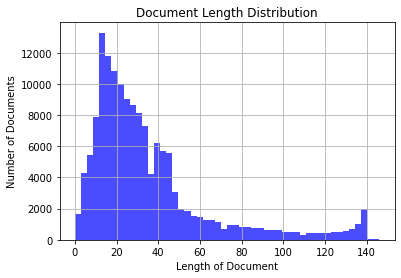

Maximum Length: 146
Minimum Length: 0
Average Length: 35.20


In [9]:
#데이터 분석 - 길이
lengths_train = [len(str(document)) for document in dataset['train']['document']]

import matplotlib.pyplot as plt

plt.hist(lengths_train, bins=50, facecolor='blue', alpha=0.7)
plt.title('Document Length Distribution')
plt.xlabel('Length of Document')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

max_length = max(lengths_train)
min_length = min(lengths_train)
avg_length = sum(lengths_train) / len(lengths_train)

print(f"Maximum Length: {max_length}")
print(f"Minimum Length: {min_length}")
print(f"Average Length: {avg_length:.2f}")


## STEP 2. klue/bert-base model 및 tokenizer 불러오기

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [11]:
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
#PyTorch 버전이 'frombuffer' 메서드를 지원하지 않는 오류를 해결하기 위해 최신 버전으로 업데이트
#pip install torch --upgrade

## STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기

### tokenizer로 데이터 전처리하기

In [16]:
# 토큰화 함수
def transform(data):
    return tokenizer(
        data['document'],
        truncation=True,
        max_length = 100,
        padding='max_length',
        return_token_type_ids=False,
    )

In [17]:
# transform 테스트
for i in range(5):
    tokens = transform(dataset['train'][i])
    print(tokens)

{'input_ids': [2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'input_ids': [2, 1963, 18, 18, 18, 11811, 2178, 2088, 28883, 16516, 2776, 18, 18, 18, 18, 10737, 2156, 2015, 2446, 2232, 6758, 2118, 1380, 6074, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [18]:
# 토큰화
train_dataset = dataset['train'].map(transform, batched=True)
test_dataset = dataset['test'].map(transform, batched=True)

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [19]:
#토큰화 확인
print("Train_dataset_Features:", train_dataset.features)
print()

print("Test_dataset_Features:", test_dataset.features)

Train_dataset_Features: {'id': Value(dtype='string', id=None), 'document': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

Test_dataset_Features: {'id': Value(dtype='string', id=None), 'document': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


### model 학습 진행하기

#### -TrainingArguments 

Hugging Face의 Transformer 라이브러리에서 제공하는 클래스로, 모델 학습과 관련된 많은 인자들을 캡슐화한다. 

이 클래스의 인스턴스는 주로 'Trainer'클래스와 함께 사용된다. 

In [20]:
#Huggingface의 'Trainer' 클래스를 PyTorch와 함께 사용하기 위한 업데이트
#!pip install accelerate -U
#!pip install transformers[torch]

In [35]:
from transformers import Trainer, TrainingArguments

# 가중치를 저장할 위치
output_dir = os.getenv('HOME') + '/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir,                         # 모델 및 훈련 결과를 저장할 디렉토리 
    evaluation_strategy="steps",        # 언제 평가를 수행할지 결정. 'epoch'로 설정하면 각 에포크 끝에 평가가 실행
    eval_steps=50,                      #원래는 'epoch'로 하였지만, epoch = 1로 지정하였기에 'steps'로 변경
    learning_rate = 2e-5,               # 학습률로, 옵티마이저가 사용하는 스텝 크기를 결정
    per_device_train_batch_size = 4,    # 각 장치당 train 배치 크기
    per_device_eval_batch_size = 4,     # 각 장치당 evaulation 배치 크기
    num_train_epochs = 1,               # 전체 데이터셋에 대한 훈련 반복 횟수
    weight_decay = 0.01,                # 가중치 감소는 정규화 기술로, 너무 큰 가중치를 갖는 모델 파라미터에 대한 패널티를 부과하여 오버피팅을 줄임
    load_best_model_at_end=True
)

#### -Metric

In [22]:
import datasets

metric = datasets.load_metric('accuracy')

/tmp/ipykernel_436/1362401404.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('accuracy')


In [23]:
# metric 함수
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

#### -Trainer

딥러닝 모델의 학습, 평가, 예측 등을 간단하고 효율적으로 수행하는 Transformers 라이브러리의 클래스

In [36]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_threshold=0.001, early_stopping_patience=3)]
)

In [37]:
#모델 학습
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,No log,0.793912,0.867620
100,No log,0.586717,0.866580
150,No log,0.813167,0.860460
200,No log,0.792827,0.857060
250,No log,0.668249,0.855580
300,No log,0.742641,0.852940
350,No log,0.778706,0.857460
400,No log,0.745933,0.859900
450,No log,0.938999,0.835720
500,0.234300,0.723080,0.859740


TrainOutput(global_step=750, training_loss=0.21115267435709636, metrics={'train_runtime': 5129.8188, 'train_samples_per_second': 29.241, 'train_steps_per_second': 7.31, 'total_flos': 154166634000000.0, 'train_loss': 0.21115267435709636, 'epoch': 0.02})

## STEP 4. Fine-tuning을 통하여 모델 성능(accuracy) 향상시키기

dropout을 통해 모델 성능을 향상시켜보자

In [ ]:
from transformers import BertConfig, BertForSequenceClassification, Trainer, TrainingArguments

# 모델 설정 및 모델 로드
config = BertConfig.from_pretrained("klue/bert-base")
config.attention_probs_dropout_prob = 0.1   # Attention dropout을 설정
config.hidden_dropout_prob = 0.1            # Hidden layer dropout을 설정

model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', config=config)

# TrainingArguments 및 Trainer 설정
training_args = TrainingArguments(
    output_dir,
    evaluation_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_threshold=0.001, early_stopping_patience=3)]
)

# 학습
trainer.train()


## STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교

### Bucketing:

시퀀스의 길이가 다양할 때, 모든 시퀀스를 가장 긴 시퀀스의 길이에 맞춰 패딩을 추가하여 처리하는 대신, 유사한 길이의 시퀀스끼리 그룹화(bucket)하여 처리하는 방식. 

How to use?

 1. 데이터를 길이별로 정렬하거나, 길이 범위에 따라 여러 버킷을 정의한다.
 2. 각 버킷에 해당하는 데이터 포인트를 해당 버킷에 할당한다.
 3. 학습 시, 각 버킷에서 배치를 샘플링하고, 해당 버킷의 최대 시퀀스 길이에 맞춰 패딩을 추가한다. 
 
 ### Dynamic padding:
 
 각 배치의 시퀀스들을 해당 배치에서 가장 긴 시퀀스의 길이에 맞추어 패딩하는 방식.
 
 
 ### Data Collator:
 
 딥러닝 프레임워크의 데이터 loader와 함께 작동하여 배치 데이터를 어떻게 처리할 지 결정하는 함수 또는 객체.
 
 ex. 다양한 길이의 시퀀스로 구성된 텍스트 데이터를 배치로 그룹하고 필요한 처리(예: dynamic padding)를 적용
 
 Hugging Face의 Transformer 라이브러리에서는 'DataCollator' 클래스를 제공.
 
 ### 'group_by_length':
 
 Hugging Face의 Transformer 라이브러리의 'TrainingArguments' 클래스 내에 있는 인자로, dynamic padding과 bucketing을 위한 설정. 
 
 기본값은 'False'이고, 'True'로 설정하면 훈련 데이터의 예제들이 유사한 길이에 따라 그룹화된다. 
 

In [ ]:
# 기존 모델 삭제
del model

# pre-trained 모델 새로 불러오기
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")

In [ ]:
# 패딩 없는 토큰화 함수
def transform_without_padding(data):
    return tokenizer(
        data['document'],
        truncation=True,
        return_token_type_ids=False,
    )

# 토큰화
train_dataset = dataset['train'].map(transform_without_padding, batched=True)
test_dataset = dataset['test'].map(transform_without_padding, batched=True)

In [ ]:
# TrainingArguments 설정
training_arguments = TrainingArguments(
    output_dir,
    evaluation_strategy='steps',
    learning_rate=2e-5,
    #per_device_train_batch_size=4, # Dynamic Padding으로 더 큰 batch로 돌릴 수 있도록
    #per_device_eval_batch_size=4,  # 직접 지정한 batch_size를 해제
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    group_by_length=True # 길이가 비슷한 데이터끼리 묶기
)

In [ ]:
# Trainer 설정
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_threshold=0.001, early_stopping_patience=3)    
    data_collator=data_collator # data_collator 추가
)

In [ ]:
trainer.train()